# Project Pokrovskiy Sviatoslav

## Paper: BinaryConnect: Training Deep Neural Networks with binary weights during propagations

The main point of the selected article that all my privious expirience using NN was finished at the moment of training then my computer could not make necessary calculations. I keen on studing varios way to using the deep leaning metods on not such power devices.
In this part of project i try to understand the approach of BinaryConnect and use it in fasion MNIST dataset.
The authors use library PyLearn2 wich doesn't work on python3 and higher. It was a great problem for me, but i use their code for understading using of BinaryConnect.
Here i use pytorch.

Marking up the clothing category

In [1]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

### Customization the layers and conv2d for BinaryConnect

In [2]:
import torch
from torch.nn import Module, Conv2d, Linear
from torch.nn.functional import linear, conv2d

def Binarize(tensor,quant_mode='det'):
    if quant_mode=='det':
        return tensor.sign()
    if quant_mode=='bin':
        return (tensor>=0).type(type(tensor))*2-1
    else:
        return tensor.add_(1).div_(2).add_(torch.rand(tensor.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)


class BNNLinear(Linear):

    def __init__(self, *kargs, **kwargs):
        super(BNNLinear, self).__init__(*kargs, **kwargs)
        self.register_buffer('weight_org', self.weight.data.clone())

    def forward(self, input):

        if (input.size(1) != 784) and (input.size(1) != 3072):
            input.data=Binarize(input.data)
            
        self.weight.data=Binarize(self.weight_org)
        out = linear(input, self.weight)

        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out
    

class BNNConv2d(Conv2d):

    def __init__(self, *kargs, **kwargs):
        super(BNNConv2d, self).__init__(*kargs, **kwargs)
        self.register_buffer('weight_org', self.weight.data.clone())

    def forward(self, input):
        if input.size(1) != 3:
            input.data = Binarize(input.data)
        
        self.weight.data=Binarize(self.weight_org)
        

        out = conv2d(input, self.weight, None, self.stride,
                                   self.padding, self.dilation, self.groups)

        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1, 1, 1).expand_as(out)

        return out
    

### Customization the model of BNN

In [3]:
import torch.nn as nn

class BNNCaffenet(nn.Module):

    def __init__(self, num_classes=10):
        super(BNNCaffenet, self).__init__()
 
        self.features = nn.Sequential(
                
                BNNConv2d(1, 96, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(96),
                nn.Hardtanh(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True),
                
                BNNConv2d(96, 192, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(192),
                nn.Hardtanh(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True),
                
                BNNConv2d(192, 288, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(288),
                nn.Hardtanh(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True),
                
                nn.Flatten(),
                nn.BatchNorm1d(4608),
                nn.Hardtanh(inplace=True),
                BNNLinear(4608, num_classes),
                nn.BatchNorm1d(num_classes, affine=False),
                nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        return self.features(x)


    def init_w(self):
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
        return


def bnn_caffenet(num_classes=10):
    return BNNCaffenet(num_classes)


### Customization the classifier of the model and saving the best model

In [4]:
import os
import numpy as np
from torch import save, no_grad
from tqdm import tqdm
import shutil


class Classifier():
    def __init__(self, model, train_loader=None, test_loader=None, device=None):
        super().__init__()
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device


    @staticmethod
    def save_checkpoint(state, is_best, checkpoint):
        head, tail = os.path.split(checkpoint)
        if not os.path.exists(head):
            os.makedirs(head)

        filename = os.path.join(head, '{0}_checkpoint.pth.tar'.format(tail))
        save(state, filename)
        if is_best:
            shutil.copyfile(filename, os.path.join(head,
                '{0}_best.pth.tar'.format(tail)))

        return

    def test(self, criterion):
        self.model.eval()
        top1 = 0
        test_loss = 0.

        with no_grad():
            for data, target in tqdm(self.test_loader):
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)      
                top1 += pred.eq(target.view_as(pred)).sum().item()

        top1_acc = 100. * top1 / len(self.test_loader.sampler)

        return top1_acc


    def top1_accuracy(self):
        return top1_accuracy(self.model, self.test_loader, self.device)


    
    def train_step(self, criterion, optimizer):
        losses = []
        for data, target in tqdm(self.train_loader,
                total=len(self.train_loader)):
            data, target = data.to(self.device), target.to(self.device)
            output = self.model(data)
            loss = criterion(output, target)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            for p in self.model.modules():
                if hasattr(p, 'weight_org'):
                    p.weight.data.copy_(p.weight_org)
            optimizer.step()
            for p in self.model.modules():
                if hasattr(p, 'weight_org'):
                    p.weight_org.data.copy_(p.weight.data.clamp_(-1,1))
        return losses
  
    
    def train(self, criterion, optimizer, epochs, scheduler,
            checkpoint=None):

        if checkpoint is None:
            raise ValueError('Specify a valid checkpoint')

        
        best_accuracy = 0.

        losses = []
        accuracies = []

        for epoch in range(1, epochs+1):
            self.model.train()
            epoch_losses = self.train_step(criterion, optimizer)
            losses += epoch_losses
            epoch_losses = np.array(epoch_losses)
            lr = optimizer.param_groups[0]['lr']  
            test_accuracy = self.test(criterion)
            accuracies.append(test_accuracy)
            if scheduler:     
                scheduler.step()
            is_best = test_accuracy > best_accuracy
            if is_best:
                best_accuracy = test_accuracy
            
            print('Train Epoch {0}\t Loss: {1:.6f}\t Test Accuracy {2:.3f} \t lr: {3:.4f}'
                    .format(epoch, epoch_losses.mean(), test_accuracy, lr))
            print('Best accuracy: {:.3f} '.format(best_accuracy))

            self.save_checkpoint({
                'epoch': epoch+1,
                'state_dict': self.model.state_dict(),
                'best_accuracy': best_accuracy,
                'optimizer': optimizer.state_dict(),
                'criterion': criterion,
                }, is_best, checkpoint)

        plt.plot(accuracies)
        plt.xlabel("No. of Epoch")
        plt.ylabel("Accuracies")
        plt.title("Accuracies by epoch")
        plt.show()
        return 

### Customization the model for comparison

In [5]:
class FashionNN(nn.Module):
    
    def __init__(self, num_classes = 10):
        super(FashionNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(96),
            nn.Hardtanh(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True),
            
            nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.Hardtanh(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True),
            
            nn.Conv2d(192, 288, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(288),
            nn.Hardtanh(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True),
            
            nn.Flatten(),
            nn.BatchNorm1d(4608),
            nn.Hardtanh(inplace=True),
            nn.Linear(4608, num_classes),
            nn.BatchNorm1d(num_classes, affine=False),
            nn.LogSoftmax(dim=1),
        )
    
    def forward(self, x):
        return self.features(x)
        
        return out

### Configurable parameters

In [6]:
# LR 
lr = .001
print("LR = "+str(lr))

# Steps
steps = [80,200]
print("Steps = "+str(steps))

# Gamma
gamma = 0.1
print("Gamma = "+str(gamma))

# Num_epochs
epochs = 15
print("num_epochs = "+str(epochs))

# Checkpoint
checkpoint = "results/bnn_caffenet_fasion_MNIST"
print("Checkpoint = "+str(checkpoint))
 

LR = 0.001
Steps = [80, 200]
Gamma = 0.1
num_epochs = 15
Checkpoint = results/bnn_caffenet_fasion_MNIST


### Realization of the BNN model

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.88it/s]


Train Epoch 1	 Loss: 1.390142	 Test Accuracy 66.210 	 lr: 0.0010
Best accuracy: 66.210 


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 11.11it/s]


Train Epoch 2	 Loss: 1.121486	 Test Accuracy 69.000 	 lr: 0.0010
Best accuracy: 69.000 


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 11.03it/s]


Train Epoch 3	 Loss: 1.046945	 Test Accuracy 72.550 	 lr: 0.0010
Best accuracy: 72.550 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.23it/s]


Train Epoch 4	 Loss: 1.001760	 Test Accuracy 72.920 	 lr: 0.0010
Best accuracy: 72.920 


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.99it/s]


Train Epoch 5	 Loss: 0.974674	 Test Accuracy 73.330 	 lr: 0.0010
Best accuracy: 73.330 


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 11.08it/s]


Train Epoch 6	 Loss: 0.950414	 Test Accuracy 74.890 	 lr: 0.0010
Best accuracy: 74.890 


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.77it/s]


Train Epoch 7	 Loss: 0.932130	 Test Accuracy 76.180 	 lr: 0.0010
Best accuracy: 76.180 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.17it/s]


Train Epoch 8	 Loss: 0.916437	 Test Accuracy 76.600 	 lr: 0.0010
Best accuracy: 76.600 


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.91it/s]


Train Epoch 9	 Loss: 0.903156	 Test Accuracy 77.570 	 lr: 0.0010
Best accuracy: 77.570 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.19it/s]


Train Epoch 10	 Loss: 0.888029	 Test Accuracy 76.990 	 lr: 0.0010
Best accuracy: 77.570 


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 11.06it/s]


Train Epoch 11	 Loss: 0.877136	 Test Accuracy 78.310 	 lr: 0.0010
Best accuracy: 78.310 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.14it/s]


Train Epoch 12	 Loss: 0.869191	 Test Accuracy 78.070 	 lr: 0.0010
Best accuracy: 78.310 


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.53it/s]


Train Epoch 13	 Loss: 0.860188	 Test Accuracy 78.550 	 lr: 0.0010
Best accuracy: 78.550 


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 11.02it/s]


Train Epoch 14	 Loss: 0.853293	 Test Accuracy 78.730 	 lr: 0.0010
Best accuracy: 78.730 


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 11.00it/s]


Train Epoch 15	 Loss: 0.844723	 Test Accuracy 78.740 	 lr: 0.0010
Best accuracy: 78.740 


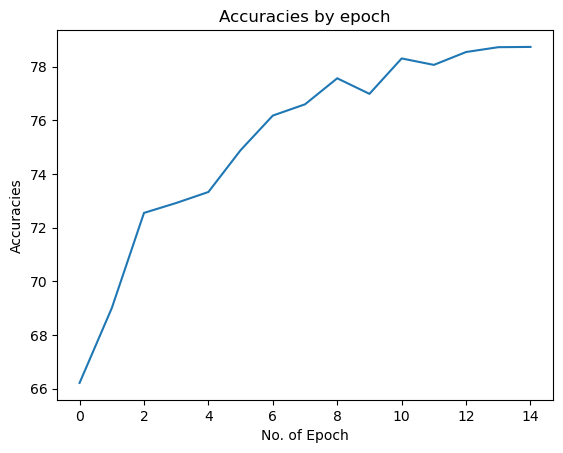

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import importlib
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)

model = BNNCaffenet()
model.to(device)


classification = Classifier(model, train_loader, test_loader, device)

criterion = torch.nn.CrossEntropyLoss()
criterion.to(device)

if hasattr(model, 'init_w'):
    model.init_w()


optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=0.9, weight_decay=1e-5)
#print(optimizer)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, steps, gamma=gamma)

classification.train(criterion, optimizer, epochs, scheduler, checkpoint)

### Accuracy by categories

In [10]:
from torch.autograd import Variable
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))



Accuracy of T-shirt/Top: 77.10%
Accuracy of Trouser: 91.00%
Accuracy of Pullover: 68.70%
Accuracy of Dress: 85.70%
Accuracy of Coat: 58.80%
Accuracy of Sandal: 87.00%
Accuracy of Shirt: 45.40%
Accuracy of Sneaker: 88.70%
Accuracy of Bag: 93.40%
Accuracy of Ankle Boot: 91.60%


### Realization of the alternative model

100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.78it/s]


Train Epoch 1	 Loss: 0.711111	 Test Accuracy 87.160 	 lr: 0.0010
Best accuracy: 87.160 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.68it/s]


Train Epoch 2	 Loss: 0.593765	 Test Accuracy 88.970 	 lr: 0.0010
Best accuracy: 88.970 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.40it/s]


Train Epoch 3	 Loss: 0.558925	 Test Accuracy 89.670 	 lr: 0.0010
Best accuracy: 89.670 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.58it/s]


Train Epoch 4	 Loss: 0.535075	 Test Accuracy 90.170 	 lr: 0.0010
Best accuracy: 90.170 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.72it/s]


Train Epoch 5	 Loss: 0.516362	 Test Accuracy 90.700 	 lr: 0.0010
Best accuracy: 90.700 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.59it/s]


Train Epoch 6	 Loss: 0.500087	 Test Accuracy 90.900 	 lr: 0.0010
Best accuracy: 90.900 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.95it/s]


Train Epoch 7	 Loss: 0.486317	 Test Accuracy 91.090 	 lr: 0.0010
Best accuracy: 91.090 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.62it/s]


Train Epoch 8	 Loss: 0.473538	 Test Accuracy 91.020 	 lr: 0.0010
Best accuracy: 91.090 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.57it/s]


Train Epoch 9	 Loss: 0.461719	 Test Accuracy 91.220 	 lr: 0.0010
Best accuracy: 91.220 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.71it/s]


Train Epoch 10	 Loss: 0.451378	 Test Accuracy 91.270 	 lr: 0.0010
Best accuracy: 91.270 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.67it/s]


Train Epoch 11	 Loss: 0.441996	 Test Accuracy 91.410 	 lr: 0.0010
Best accuracy: 91.410 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.67it/s]


Train Epoch 12	 Loss: 0.433544	 Test Accuracy 91.620 	 lr: 0.0010
Best accuracy: 91.620 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.60it/s]


Train Epoch 13	 Loss: 0.425485	 Test Accuracy 91.420 	 lr: 0.0010
Best accuracy: 91.620 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.60it/s]


Train Epoch 14	 Loss: 0.418874	 Test Accuracy 91.560 	 lr: 0.0010
Best accuracy: 91.620 


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.67it/s]


Train Epoch 15	 Loss: 0.412615	 Test Accuracy 91.440 	 lr: 0.0010
Best accuracy: 91.620 


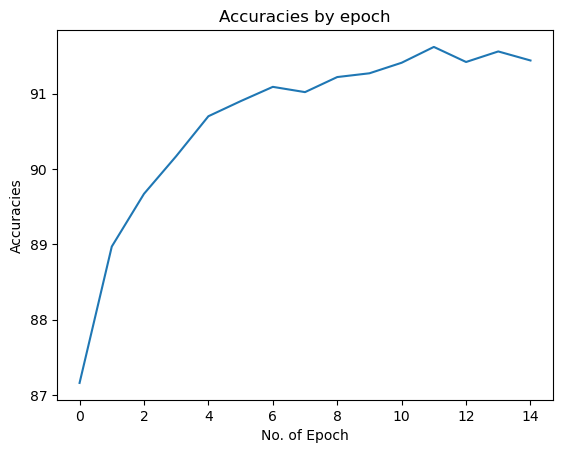

In [11]:
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)

model_1 = FashionNN()
model_1.to(device)


classification = Classifier(model_1, train_loader, test_loader, device)

criterion = torch.nn.CrossEntropyLoss()
criterion.to(device)

#if hasattr(model_1, 'init_w'):
#    model.init_w()


optimizer = torch.optim.SGD(model_1.parameters(), lr=lr,momentum=0.9, weight_decay=1e-5)
#print(optimizer)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, steps, gamma=gamma)

classification.train(criterion, optimizer, epochs, scheduler, checkpoint)

### Accuracy by categories

In [12]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))


Accuracy of T-shirt/Top: 77.10%
Accuracy of Trouser: 91.00%
Accuracy of Pullover: 68.70%
Accuracy of Dress: 85.70%
Accuracy of Coat: 58.80%
Accuracy of Sandal: 87.00%
Accuracy of Shirt: 45.40%
Accuracy of Sneaker: 88.70%
Accuracy of Bag: 93.40%
Accuracy of Ankle Boot: 91.60%
